# WNBL PCA

Breakdown and identify most important features.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import cluster, decomposition, preprocessing
import wnbl

data_path = "..\\data"

In [2]:
# concatenate all teams by season info, drop duplicates to define unique TeamID and name mapping
teams_df = wnbl.load_csv(data_path+"\\teams",'teams')
teams_df = teams_df.drop_duplicates().reset_index()
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   25 non-null     int64 
 1   Team    25 non-null     object
 2   TeamID  25 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 728.0+ bytes


In [3]:
# concatenate all players by season stats
players_df = wnbl.load_csv(data_path+"\\players",'players',include_id=True)

# fix html encoded apostrophes iin names
players_df['Player'] = players_df['Player'].str.replace("&#039;","'")
players_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3004 entries, 0 to 105
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  3004 non-null   object 
 1   G       3004 non-null   int64  
 2   PTS     3004 non-null   int64  
 3   FGA     3004 non-null   int64  
 4   FGM     3004 non-null   int64  
 5   FG%     3004 non-null   float64
 6   3PA     3004 non-null   int64  
 7   3PM     3004 non-null   int64  
 8   3P%     3004 non-null   float64
 9   FTA     3004 non-null   int64  
 10  FTM     3004 non-null   int64  
 11  FT%     3004 non-null   float64
 12  DEF     3004 non-null   int64  
 13  OFF     3004 non-null   int64  
 14  REB     3004 non-null   int64  
 15  AST     3004 non-null   int64  
 16  BLK     3004 non-null   int64  
 17  STL     3004 non-null   int64  
 18  TO      3004 non-null   int64  
 19  TeamID  3004 non-null   int64  
 20  CompID  3004 non-null   int32  
dtypes: float64(3), int32(1), int64(16), ob

In [4]:
def tweak_players(df):
    return(df
        .drop(columns=['Player','TeamID','CompID','REB'])
        )

<AxesSubplot:>

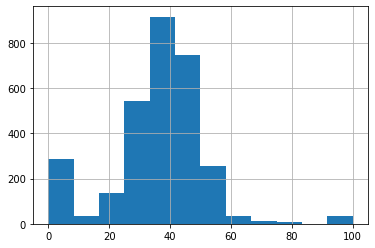

In [7]:
tweak_players(players_df)['FG%'].hist(bins=12)

## EDA and Correlations

In [6]:
tweak_players(players_df).corr().style.background_gradient(cmap='RdBu',vmin=-1,vmax=1)

,G,PTS,FGA,FGM,FG%,3PA,3PM,3P%,FTA,FTM,FT%,DEF,OFF,AST,BLK,STL,TO
G,1.000000,0.652366,0.684102,0.648642,0.364051,0.499613,0.465440,0.291022,0.588374,0.574534,0.569267,0.640986,0.609708,0.581861,0.402747,0.585974,0.695900
PTS,0.652366,1.000000,0.983268,0.992836,0.375931,0.669095,0.659572,0.334748,0.907094,0.914406,0.474724,0.861323,0.769114,0.711010,0.560434,0.742515,0.822106
FGA,0.684102,0.983268,1.000000,0.980803,0.340848,0.696494,0.665958,0.324500,0.870062,0.872534,0.483736,0.859397,0.763738,0.728742,0.544228,0.757443,0.848245
FGM,0.648642,0.992836,0.980803,1.000000,0.390464,0.616163,0.605029,0.312308,0.879229,0.879297,0.457812,0.872133,0.790872,0.682706,0.590477,0.725389,0.809852
FG%,0.364051,0.375931,0.340848,0.390464,1.000000,0.145902,0.169486,0.310628,0.329279,0.318889,0.349214,0.351799,0.355244,0.227855,0.271633,0.264062,0.305837
3PA,0.499613,0.669095,0.696494,0.616163,0.145902,1.000000,0.975400,0.416931,0.476556,0.516911,0.393967,0.452722,0.253350,0.682247,0.133731,0.616983,0.601063
3PM,0.465440,0.659572,0.665958,0.605029,0.169486,0.975400,1.000000,0.461173,0.455253,0.498501,0.375046,0.428045,0.235926,0.650884,0.118471,0.584919,0.556871
3P%,0.291022,0.334748,0.324500,0.312308,0.310628,0.416931,0.461173,1.000000,0.232472,0.257186,0.325306,0.223290,0.138995,0.325637,0.053051,0.304424,0.286621
FTA,0.588374,0.907094,0.870062,0.879229,0.329279,0.476556,0.455253,0.232472,1.000000,0.985929,0.418829,0.814443,0.779219,0.623912,0.544123,0.669231,0.779850
FTM,0.574534,0.914406,0.872534,0.879297,0.318889,0.516911,0.498501,0.257186,0.985929,1.000000,0.453367,0.795702,0.740779,0.643891,0.513419,0.674367,0.768574


<AxesSubplot:xlabel='FG%', ylabel='PTS'>

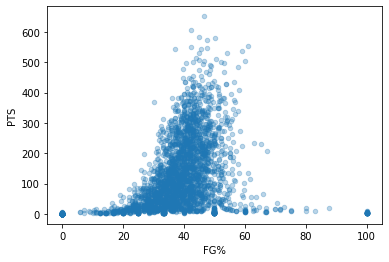

In [8]:
# initial plot to identify potential thresholds
(tweak_players(players_df)
 .plot.scatter(x='FG%',y='PTS',alpha=0.3)
)

In [19]:
# pearson correlation (linear based), filtered by impressions
(tweak_players(players_df)
    .query("FGM > 0")
    .corr().style.background_gradient(cmap='RdBu',vmin=-1,vmax=1)
)

,G,PTS,FGA,FGM,FG%,3PA,3PM,3P%,FTA,FTM,FT%,DEF,OFF,AST,BLK,STL,TO
G,1.000000,0.606827,0.637880,0.602493,-0.035061,0.455064,0.424810,0.134494,0.538906,0.527980,0.429113,0.593285,0.558304,0.537207,0.360702,0.531146,0.641597
PTS,0.606827,1.000000,0.981470,0.992015,0.219660,0.643215,0.636875,0.251089,0.897854,0.906787,0.407339,0.845487,0.743671,0.682887,0.534601,0.714752,0.799490
FGA,0.637880,0.981470,1.000000,0.978722,0.145070,0.672711,0.643751,0.233367,0.856803,0.860905,0.408560,0.842462,0.736253,0.701382,0.516637,0.729936,0.826928
FGM,0.602493,0.992015,0.978722,1.000000,0.242379,0.585602,0.577802,0.225990,0.867095,0.868166,0.386153,0.857570,0.767888,0.651781,0.567001,0.695811,0.785665
FG%,-0.035061,0.219660,0.145070,0.242379,1.000000,-0.044587,0.012983,0.092277,0.177026,0.174180,-0.036201,0.185252,0.200101,0.037173,0.186926,0.067397,0.064332
3PA,0.455064,0.643215,0.672711,0.585602,-0.044587,1.000000,0.974259,0.365215,0.436746,0.481672,0.345092,0.407839,0.192747,0.659348,0.089200,0.587519,0.567106
3PM,0.424810,0.636875,0.643751,0.577802,0.012983,0.974259,1.000000,0.419724,0.418260,0.465828,0.333529,0.386295,0.179994,0.628742,0.077178,0.556861,0.523943
3P%,0.134494,0.251089,0.233367,0.225990,0.092277,0.365215,0.419724,1.000000,0.145269,0.176980,0.195568,0.126333,0.035002,0.253030,-0.018267,0.222262,0.182369
FTA,0.538906,0.897854,0.856803,0.867095,0.177026,0.436746,0.418260,0.145269,1.000000,0.984769,0.346234,0.795567,0.757262,0.590012,0.518128,0.636819,0.755848
FTM,0.527980,0.906787,0.860905,0.868166,0.174180,0.481672,0.465828,0.176980,0.984769,1.000000,0.397674,0.776203,0.716386,0.613213,0.486082,0.644096,0.745377


In [20]:
# pearson correlation (linear based), filtered by impressions
(tweak_players(players_df)
    .query('PTS > 400')
    .corr(method='spearman').style.background_gradient(cmap='RdBu',vmin=-1,vmax=1)
)

,G,PTS,FGA,FGM,FG%,3PA,3PM,3P%,FTA,FTM,FT%,DEF,OFF,AST,BLK,STL,TO
G,1.000000,0.172215,0.218606,-0.033844,-0.377803,0.312761,0.282947,-0.033585,0.051187,0.150793,0.144024,-0.048612,-0.090685,0.475298,-0.261030,0.097125,0.393647
PTS,0.172215,1.000000,0.727014,0.834068,0.074168,0.043224,-0.010656,-0.297851,0.586860,0.579062,-0.151745,0.405172,0.347594,0.024408,0.325752,0.255565,0.263821
FGA,0.218606,0.727014,1.000000,0.616008,-0.432183,0.319029,0.233031,-0.251551,0.229411,0.206647,-0.104345,0.204786,0.100445,0.205009,0.025964,0.494835,0.296131
FGM,-0.033844,0.834068,0.616008,1.000000,0.390477,-0.266360,-0.333059,-0.429856,0.389027,0.300189,-0.343206,0.386469,0.425777,-0.092846,0.412588,0.155821,0.123219
FG%,-0.377803,0.074168,-0.432183,0.390477,1.000000,-0.665126,-0.629036,-0.164838,0.110347,0.026356,-0.277159,0.240474,0.322953,-0.371178,0.434844,-0.339486,-0.268682
3PA,0.312761,0.043224,0.319029,-0.266360,-0.665126,1.000000,0.977538,0.408559,-0.289422,-0.158376,0.406461,-0.487977,-0.522934,0.576132,-0.603329,0.395830,0.216719
3PM,0.282947,-0.010656,0.233031,-0.333059,-0.629036,0.977538,1.000000,0.551363,-0.314996,-0.186433,0.400532,-0.489248,-0.532070,0.546592,-0.608608,0.374048,0.162607
3P%,-0.033585,-0.297851,-0.251551,-0.429856,-0.164838,0.408559,0.551363,1.000000,-0.310398,-0.275078,0.138297,-0.332057,-0.252367,0.110268,-0.339068,0.017890,-0.181463
FTA,0.051187,0.586860,0.229411,0.389027,0.110347,-0.289422,-0.314996,-0.310398,1.000000,0.937792,-0.298943,0.536188,0.525903,-0.303293,0.482225,-0.166604,0.108130
FTM,0.150793,0.579062,0.206647,0.300189,0.026356,-0.158376,-0.186433,-0.275078,0.937792,1.000000,0.010655,0.404184,0.384451,-0.163614,0.352978,-0.127903,0.203194


<AxesSubplot:xlabel='FG%', ylabel='PTS'>

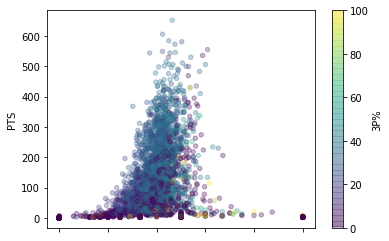

In [21]:
# White grey (default), Set1, viridis
# adjust alpha for overlapping points
(tweak_players(players_df)
    .plot.scatter(x='FG%',y='PTS',c='3P%',cmap='viridis', alpha=0.3)
)

<AxesSubplot:xlabel='FG%', ylabel='PTS'>

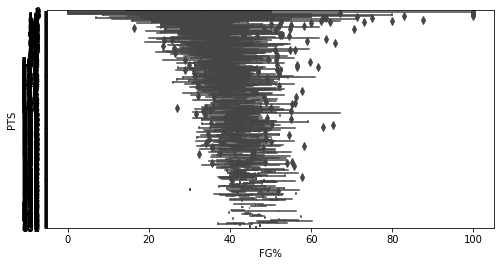

In [24]:
# boxenplot
# NB: Only works well for finite discrete values
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='FG%',y='PTS',data=tweak_players(players_df), orient='h')

In [25]:
(tweak_players(players_df)
    .assign(profile_bin=lambda df_:pd.cut(df_.PTS,bins=5))
    .groupby('profile_bin')
    #.size()
    .mean()
    .T
    .style.background_gradient(cmap='RdBu',axis=1)
)

profile_bin,"(-0.652, 130.4]","(130.4, 260.8]","(260.8, 391.2]","(391.2, 521.6]","(521.6, 652.0]"
G,12.699735,20.684593,22.433048,23.373134,24.538462
PTS,41.413793,190.260174,312.487179,439.014925,563.846154
FGA,42.738992,174.536337,270.806268,355.000000,443.153846
FGM,15.531034,72.148256,117.136752,164.776119,209.307692
FG%,32.096286,41.743895,43.553846,46.637313,47.915385
3PA,10.647745,44.156977,64.854701,74.880597,82.692308
3PM,2.937931,14.373547,22.336182,26.626866,27.230769
3P%,16.946897,27.523110,30.454131,33.240299,25.900000
FTA,11.011671,43.489826,73.507123,106.552239,150.230769
FTM,7.410610,31.584302,55.851852,82.761194,118.000000


## Clustering

In [27]:
# standardise features, ie. mean=0 std_dev=1
cleaned = tweak_players(players_df)
X_std = pd.DataFrame(preprocessing.StandardScaler().fit_transform(cleaned),
                     columns=cleaned.columns)

X_std.head()

,G,PTS,FGA,FGM,FG%,3PA,3PM,3P%,FTA,FTM,FT%,DEF,OFF,AST,BLK,STL,TO
0,1.591719,0.234506,0.017179,0.234271,0.867479,-0.303518,-0.283223,0.503628,0.637916,0.438233,0.169030,0.241254,1.093130,-0.088686,0.337367,-0.355970,0.160881
1,1.591719,3.917976,3.582115,4.287048,0.886118,0.134229,-0.119371,0.063291,3.383848,3.478639,0.598616,3.581252,2.528295,1.733814,3.134876,1.558372,1.958688
2,0.798829,-0.764688,-0.807026,-0.795716,-0.170070,-0.566166,-0.447075,1.090745,-0.604291,-0.589509,0.351689,-0.396150,-0.342034,-0.343836,-0.415808,-0.442986,-0.714973
3,1.591719,1.343781,1.367684,1.241867,0.289682,2.381327,2.666113,0.842739,0.572537,0.652346,0.632442,0.623697,0.561588,2.098314,1.090543,0.340154,1.036736
4,1.459571,-0.112671,-0.062262,-0.191159,-0.045813,0.863806,0.781815,0.544119,-0.179325,-0.246929,0.189326,-0.319661,-0.767268,0.057114,-0.631001,-0.791048,-0.253997


In [28]:
X_std.isna().sum()

G      0
PTS    0
FGA    0
FGM    0
FG%    0
3PA    0
3PM    0
3P%    0
FTA    0
FTM    0
FT%    0
DEF    0
OFF    0
AST    0
BLK    0
STL    0
TO     0
dtype: int64

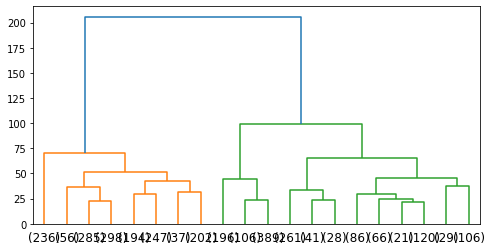

In [29]:
fig,ax = plt.subplots(figsize=(8,4))

_ = hierarchy.dendrogram(hierarchy.linkage(X_std,method='ward'),truncate_mode='lastp',p=20)

In [38]:
clus = cluster.AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='ward')
clus.fit(X_std)

AgglomerativeClustering(n_clusters=5)

In [39]:
(tweak_players(players_df)
    .assign(label=clus.fit_predict(X_std))
    .groupby('label')
    .mean()
    .T
    .style.background_gradient('RdBu',axis=1)
)

label,0,1,2,3,4
G,12.379075,21.852804,20.434153,3.203390,22.339394
PTS,34.968916,293.565421,137.373372,0.021186,268.760606
FGA,35.934041,251.714953,131.138929,1.093220,240.112121
FGM,13.242608,112.121495,52.898698,0.008475,96.303030
FG%,36.746626,44.296963,39.947757,0.105932,39.998485
3PA,8.683851,38.310748,30.322721,0.343220,92.187879
3PM,2.398787,12.247664,9.429812,0.000000,31.766667
3P%,18.896588,27.701869,23.307815,0.000000,34.082727
FTA,9.091736,76.780374,31.839363,0.084746,56.654545
FTM,6.080364,57.044393,22.143271,0.004237,44.378788


In [43]:
# show observations (players) associated with label (cluster)
(tweak_players(players_df)
    .assign(label=clus.fit_predict(X_std))
    .query('label == 4')
)

,G,PTS,FGA,FGM,FG%,3PA,3PM,3P%,FTA,FTM,FT%,DEF,OFF,AST,BLK,STL,TO,label
3,28,277,246,100,40.7,108,41,38.0,46,36,78.3,64,29,82,16,15,48,4
5,28,253,229,86,37.6,93,27,29.0,68,54,79.4,47,28,76,3,15,53,4
6,28,293,200,96,48.0,70,34,48.6,93,67,72.0,77,20,66,5,36,72,4
13,26,303,253,108,42.7,136,59,43.4,37,28,75.7,73,23,15,10,13,33,4
17,25,260,272,95,34.9,117,39,33.3,35,31,88.6,61,25,82,6,29,45,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,21,249,214,89,42.0,33,12,36.0,69,59,86.0,54,19,59,4,17,49,4
79,22,180,204,63,31.0,77,21,27.0,41,33,80.0,65,27,62,7,28,46,4
81,22,196,208,56,27.0,100,21,21.0,89,63,71.0,46,6,76,1,10,54,4
93,22,236,235,85,36.0,122,41,34.0,31,25,81.0,41,14,35,1,10,42,4


<AxesSubplot:xlabel='FG%', ylabel='PTS'>

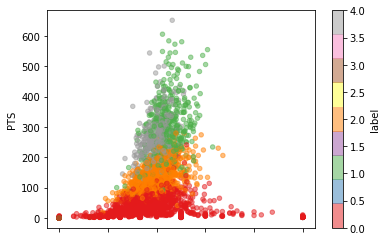

In [44]:
(tweak_players(players_df)
    .assign(label=clus.fit_predict(X_std))
    .plot.scatter(x='FG%',y='PTS',c='label',cmap='Set1',alpha=.5)
)

## PCA

In [46]:
# which linear combination of features gives greatest variation
# adjoining features are orthogonal
pca = decomposition.PCA()
X_pca = pca.fit_transform(X_std)
X_pca

array([[ 1.21903531e+00,  9.36754263e-01,  1.21561510e+00, ...,
         2.99769490e-02,  1.39659014e-01, -7.36368569e-05],
       [ 9.56922027e+00,  3.78919310e+00, -8.96676747e-01, ...,
        -1.06702111e-01,  1.82454967e-01, -6.02391183e-04],
       [-1.56254470e+00, -4.70627139e-01,  1.27387356e+00, ...,
        -7.81321768e-03,  2.75942897e-03, -8.79241364e-05],
       ...,
       [-4.38761321e+00,  2.06107314e-01, -2.33480896e+00, ...,
        -2.81879440e-02,  8.61500163e-03, -1.15283504e-05],
       [ 7.24737353e-01,  1.68534358e+00,  5.73957123e-01, ...,
         1.83306958e-01, -4.77353872e-02,  2.79109563e-05],
       [-2.31177040e-01, -9.26288564e-01,  3.49521032e-01, ...,
         7.67825183e-02, -9.83519552e-02,  2.51735966e-05]])

In [47]:
# Express PCA as dataframe and set PC(n) column names
pd.DataFrame(X_pca,columns=[f'PC{n+1}' for n in range(X_pca.shape[1])])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,1.219035,0.936754,1.215615,-0.152693,0.079834,-0.119499,0.145837,-1.300922,-0.208872,0.245402,0.340560,-0.280258,-0.234447,0.067535,0.029977,0.139659,-0.000074
1,9.569220,3.789193,-0.896677,1.056430,0.051284,-0.461082,-0.626632,0.064090,-0.604790,-0.295253,0.169987,1.708304,0.486531,-0.014724,-0.106702,0.182455,-0.000602
2,-1.562545,-0.470627,1.273874,-0.405140,0.733182,-0.614632,0.571503,-0.625361,-0.046730,0.290384,0.389867,-0.000047,0.172924,0.061748,-0.007813,0.002759,-0.000088
3,4.612824,-2.085367,-0.318562,0.185178,0.731283,1.384534,0.277034,-0.330716,-0.857971,-0.256262,0.633578,-0.085262,-0.567871,0.167384,0.026562,-0.058123,0.000034
4,-0.088719,-1.585429,0.506446,-0.354471,0.508256,0.494016,-0.171443,-1.310719,-0.615992,0.226146,0.252253,0.107192,0.281762,-0.062322,0.070777,0.056909,-0.000052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,3.660743,-2.248833,-0.527650,-0.211282,0.278568,0.711021,0.231717,0.268731,-0.053515,-0.236405,-0.105567,-0.161056,0.305681,-0.037796,-0.039860,-0.066155,-0.000105
3000,-4.390600,0.206012,-2.333885,0.721607,0.240182,-0.330032,0.013986,0.174959,0.062773,-0.136881,0.034164,0.044030,-0.030571,0.074855,-0.029418,0.015300,-0.000014
3001,-4.387613,0.206107,-2.334809,0.722355,0.240352,-0.329625,0.012911,0.174195,0.063318,-0.138908,0.032818,0.047615,-0.031223,0.070313,-0.028188,0.008615,-0.000012
3002,0.724737,1.685344,0.573957,1.068619,0.845997,0.569154,0.611801,1.389681,-0.813558,0.628170,-0.653222,0.464074,0.114944,-0.020105,0.183307,-0.047735,0.000028


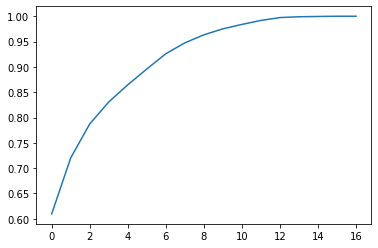

In [48]:
# trailing _ signifies calculated property fro scikit-learn
plt.plot(pca.explained_variance_ratio_.cumsum())

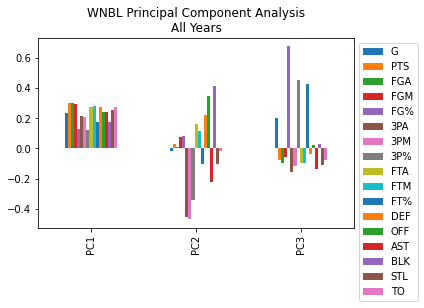

In [55]:
# feature importance = magnitude of weights
# original columns (ie. X_Std)
# index is PCn
(pd.DataFrame(pca.components_,columns=X_std.columns,
            index=[f'PC{n+1}' for n in range(X_pca.shape[1])])
     .iloc[:3]  # PC1 and PC2
     .plot.bar()
     .legend(bbox_to_anchor=(1,1))
)

plt.title("WNBL Principal Component Analysis\nAll Years")
plt.tight_layout()
plt.savefig('wnbl_pca.png')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

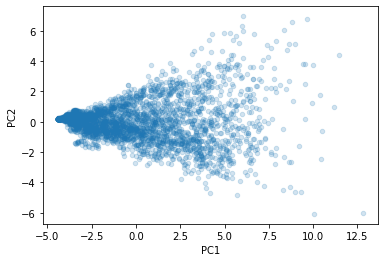

In [51]:
(pd.DataFrame(X_pca,columns=[f'PC{n+1}' for n in range(X_pca.shape[1])])
                             .plot.scatter(x='PC1',y='PC2',alpha=0.2))

In [52]:
# identify outlier
(tweak_players(players_df)
    .query('FGA == 0')
)

,G,PTS,FGA,FGM,FG%,3PA,3PM,3P%,FTA,FTM,FT%,DEF,OFF,AST,BLK,STL,TO
12,2,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0
19,1,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0
25,1,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,1,0,0,1
43,1,0,0,0,0.0,0,0,0.0,0,0,0.0,1,0,0,0,0,0
50,1,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,2,0,0,0,0.0,0,0,0.0,0,0,0.0,1,1,1,0,0,1
34,1,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0
37,1,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0,0,0
76,1,0,0,0,0.0,0,0,0.0,0,0,0.0,0,1,0,0,0,0
